In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from geotools.path_calc import address_search, get_metro_bounds
from geotools.weighting import weighting_function


In [4]:
metro_grid = pd.read_csv("metro_grid.csv", sep=";")

In [6]:
metro_grid

,lon,lat
0,-94.011000,44.471400
1,-94.002017,44.471400
2,-93.993034,44.471400
3,-94.011000,44.477810
4,-93.975067,44.471400
...,...,...
21302,-92.735392,45.387194
21303,-92.735392,45.393502
21304,-92.735392,45.399810
21305,-92.735392,45.406118


In [5]:
lat, lng = [45.147762, -93.134160]
lng, lat = metro_grid.loc[10000,:]
address_data = address_search(lng, lat, 5000.)

In [7]:
address_data

,COUNTY_PIN,STATE_PIN,ANUMBERPRE,ANUMBER,ANUMBERSUF,ST_PRE_MOD,ST_PRE_DIR,ST_PRE_TYP,ST_PRE_SEP,ST_NAME,...,SECTION,TOWNSHIP,RANGE,RANGE_DIR,PRIN_MER,PIN,VIEWID,LONGITUDE,LATITUDE,DISTANCE
0,279240042,27139-279240042,None,2360,None,None,None,None,None,Muhlenhardt,...,24,115,22,0,0,139-279240042,5057775,-93.410,44.7568,3375.045113
1,279240040,27139-279240040,None,2350,None,None,None,None,None,Muhlenhardt,...,24,115,22,0,0,139-279240040,5057774,-93.409,44.7571,3390.225145
2,279240033,27139-279240033,None,2560,None,None,None,None,None,Muhlenhardt,...,24,115,22,0,0,139-279240033,5057765,-93.411,44.7542,3115.588215
3,279240030,27139-279240030,None,2450,None,None,None,None,None,Muhlenhardt,...,24,115,22,0,0,139-279240030,5057756,-93.412,44.7558,3308.449559
4,279240022,27139-279240022,None,7802,None,None,None,None,None,Horizon,...,24,115,22,0,0,139-279240022,5057755,-93.418,44.7597,3873.174826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18755,040050040,27139-040050040,None,0,None,None,None,None,None,None,...,0,0,0,0,0,139-040050040,5005414,-93.393,44.7163,1342.297002
18756,040050020,27139-040050020,None,0,None,None,None,None,None,None,...,0,0,0,0,0,139-040050020,5005413,-93.396,44.7166,1228.448022
18757,040050011,27139-040050011,None,6146,None,None,None,None,None,White,...,0,0,0,0,0,139-040050011,5005412,-93.395,44.7163,1283.529356
18758,040040010,27139-040040010,None,6445,None,None,None,None,None,White,...,0,0,0,0,0,139-040040010,5005411,-93.389,44.7155,1576.497825


In [25]:
df = address_data
class_weights = {
    'AGRICULTURAL': 0.5,
    'APARTMENTS / COOP': 10,
    'COMMERCIAL / GOLF COURSE': 1,
    'CONDOMINIUMS': 5,
    'DOUBLE BUNGALOWS': 3,
    'INDUSTRIAL': 3,
    'MANUFACTURED HOME PARK': 10,
    None: 0,
    'RESIDENTIAL DUPLEXES': 3,
    'RESIDENTIAL SINGLE FAMILY': 2,
    'SEASONAL RECREATIONAL': 1,
    'TAX FORFEIT': 0,
    'UTILITY PROPERTY': 0
}
class_weights = {
    '100 Res 1 unit': 2,
    '105 Res 2-3 units': 2.5,
    '110 Apt 4+ units': 6,
#     '125 SRR',
#     '140 Res V Land',
#     '200 Agricultural',
#     '211 Rural Vacant Land',
    '300 Commercial': 2,
    '305 Industrial': 1.5,
#     '320 Q Golf Course',
    '901 Schools-Public': 1,
#     '911 Cemetery-Public',
#     '912 Cemetery-Private',
#     '915 Church',
#     '916 Church-Residence',
#     '917 Church-Other Res',
#     '918 Church - Other',
#     '925 Trans Housing',
#     '931 Charit Inst',
#     '940 Wetlands',
#     '941 ForestParkRefuge',
#     '942 Indian Resrv',
#     '951 Federal Property',
#     '952 State Property',
#     '955 Co Srvc Other',
#     '956 Muni Srvc Ent',
#     '958 Muni Srvc Other',
#     '962 T E Misc Co D 3',
#     '981 State Acquired',
#     '982 State Admin-DNR',
#     '983 Co Admin-TaxForf',
#     '990 InLieuTx Co D 1',
}

year_weights = lambda x: np.exp((x - 2020) / 10)
use_weight = df["USECLASS1"].map(lambda x: class_weights.get(x, 0)).values
d = use_weight * year_weights(df["YEAR_BUILT"].values)

In [20]:
from functools import reduce
# reduceaddress_data["USECLASS1"].unique()
use_classes = list(reduce(lambda a, b: a + b, [address_data[f"USECLASS{i}"].unique().tolist() for i in range(1,5)]))
set(use_classes)

{'100 Res 1 unit',
 '105 Res 2-3 units',
 '110 Apt 4+ units',
 '125 SRR',
 '140 Res V Land',
 '200 Agricultural',
 '211 Rural Vacant Land',
 '300 Commercial',
 '305 Industrial',
 '320 Q Golf Course',
 '901 Schools-Public',
 '911 Cemetery-Public',
 '912 Cemetery-Private',
 '915 Church',
 '916 Church-Residence',
 '917 Church-Other Res',
 '918 Church - Other',
 '925 Trans Housing',
 '931 Charit Inst',
 '940 Wetlands',
 '941 ForestParkRefuge',
 '942 Indian Resrv',
 '951 Federal Property',
 '952 State Property',
 '955 Co Srvc Other',
 '956 Muni Srvc Ent',
 '958 Muni Srvc Other',
 '962 T E Misc Co D 3',
 '981 State Acquired',
 '982 State Admin-DNR',
 '983 Co Admin-TaxForf',
 '990 InLieuTx Co D 1',
 None}

In [29]:
class_weights = {
    'AGRICULTURAL': 0.5,
    'APARTMENTS / COOP': 10,
    'COMMERCIAL / GOLF COURSE': 1,
    'CONDOMINIUMS': 5,
    'DOUBLE BUNGALOWS': 3,
    'INDUSTRIAL': 3,
    'MANUFACTURED HOME PARK': 10,
     None: 0,
    'RESIDENTIAL DUPLEXES': 3,
    'RESIDENTIAL SINGLE FAMILY': 2,
    'SEASONAL RECREATIONAL': 1,
    'TAX FORFEIT': 0,
    'UTILITY PROPERTY': 0
}

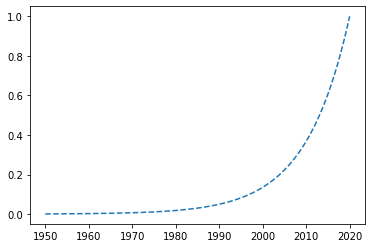

In [31]:
x = np.linspace(1950, 2020, 1000)
year_weights = lambda x: np.exp((x - 2020) / 10)
fig, ax = plt.subplots()
ax.plot(x, year_weights(x), "--")
plt.show()

In [32]:
def weighting_function(df):
    use_weight = df["USECLASS1"].map(class_weights)
    return use_weight * year_weights(df["YEAR_BUILT"])

In [33]:
address_data["WEIGHT"] = weighting_function(address_data)

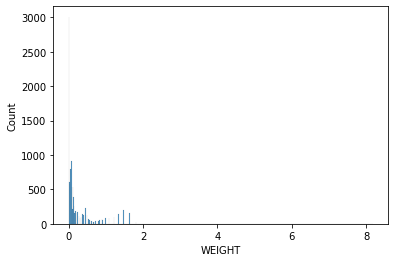

In [37]:
sns.histplot(address_data["WEIGHT"])

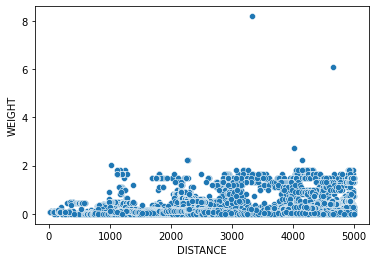

In [38]:
sns.scatterplot(y="WEIGHT", x="DISTANCE", data=address_data)

In [9]:
address_data["WEIGHT"] = address_data["USECLASS1"].apply(lambda x: class_weights[x]) *


Index(['COUNTY_PIN', 'STATE_PIN', 'ANUMBERPRE', 'ANUMBER', 'ANUMBERSUF',
       'ST_PRE_MOD', 'ST_PRE_DIR', 'ST_PRE_TYP', 'ST_PRE_SEP', 'ST_NAME',
       'ST_POS_TYP', 'ST_POS_DIR', 'ST_POS_MOD', 'SUB_TYPE1', 'SUB_ID1',
       'SUB_TYPE2', 'SUB_ID2', 'ZIP', 'ZIP4', 'CTU_NAME', 'CTU_ID_TXT',
       'POSTCOMM', 'CO_CODE', 'CO_NAME', 'STATE_CODE', 'LOT', 'BLOCK',
       'PLAT_NAME', 'OWNER_NAME', 'OWNER_MORE', 'OWN_ADD_L1', 'OWN_ADD_L2',
       'OWN_ADD_L3', 'OWN_ADD_L4', 'TAX_NAME', 'TAX_ADD_L1', 'TAX_ADD_L2',
       'TAX_ADD_L3', 'TAX_ADD_L4', 'LANDMARK', 'HOMESTEAD', 'ACRES_POLY',
       'ACRES_DEED', 'EMV_LAND', 'EMV_BLDG', 'EMV_TOTAL', 'TAX_YEAR',
       'MKT_YEAR', 'TAX_CAPAC', 'TOTAL_TAX', 'SPEC_ASSES', 'USECLASS1',
       'USECLASS2', 'USECLASS3', 'USECLASS4', 'MULTI_USES', 'TAX_EXEMPT',
       'XUSECLASS1', 'XUSECLASS2', 'XUSECLASS3', 'XUSECLASS4', 'DWELL_TYPE',
       'HOME_STYLE', 'FIN_SQ_FT', 'GARAGE', 'GARAGESQFT', 'BASEMENT',
       'HEATING', 'COOLING', 'YEAR_BUILT', 'NUM_U

In [11]:
np.unique(address_data["YEAR_BUILT"])

array([   0, 1882, 1886, 1890, 1892, 1894, 1900, 1901, 1902, 1904, 1910,
       1912, 1913, 1914, 1917, 1920, 1924, 1925, 1928, 1929, 1930, 1932,
       1934, 1935, 1936, 1938, 1939, 1940, 1941, 1942, 1943, 1945, 1946,
       1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957,
       1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
       1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
       1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019])

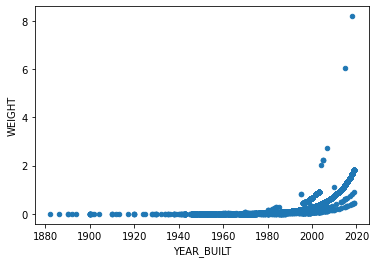

In [37]:
new_mask = address_data["YEAR_BUILT"] > 0
address_data.loc[new_mask].plot.scatter(y="WEIGHT", x="YEAR_BUILT")